In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import pandas as pd

In [3]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

print("train size", len(train_df))
print("val size", len(val_df))
print("test size", len(test_df))

train size 40001
val size 4001
test size 10000


In [4]:
train_df.sample(10)

,text,label
28090,fully network. the our (ResNet) backbone adopt...,"In our approach, we adopt the fully convolutio..."
17963,"we frameworks? temporal a event visually ""Pari...","Can we visually model a temporal event like ""P..."
16992,samples covariates the the of and outcome.,samples of the covariates and the outcome.
2540,uses describe matrix efficient techniques. low...,We describe a computationally efficient implem...
6696,can blackboard approach a clearly explained sy...,The system's interactive approach can be clear...
28022,two pairs networks. PNA aligned between node p...,PNA produces aligned node pairs between two ne...
26642,Preparing slides of each scanning parameters. ...,Preparing and scanning histopathology slides c...
34360,challenges These remain. of effective methods ...,"These methods are effective to some extent, bu..."
10577,on the state-of-the-arts approach benchmark Ou...,Our approach outperforms the state-of-the-arts...
6475,partition data is fundamental algorithms The p...,The fundamental aim of clustering algorithms i...


<AxesSubplot:>

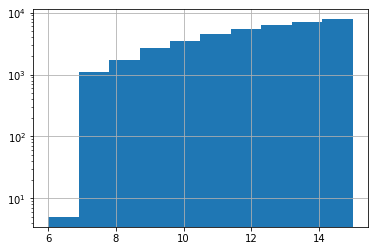

In [5]:
text_lengths = train_df["text"].apply(lambda x: len(x.split()))
text_lengths.hist(log=True)

In [6]:
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

model_name = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

(array([2.5320e+03, 1.3719e+04, 1.6117e+04, 6.9240e+03, 6.4100e+02,
        5.5000e+01, 1.0000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 9. , 14.6, 20.2, 25.8, 31.4, 37. , 42.6, 48.2, 53.8, 59.4, 65. ]),
 <BarContainer object of 10 artists>)

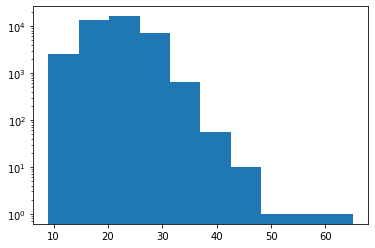

In [7]:
import matplotlib.pyplot as plt

input_tokens = tokenizer(train_df["text"].to_list()).input_ids
lengths = [len(x) for x in input_tokens]
plt.hist(lengths, log=True)

In [8]:
def tokenize_text(source, target, tokenizer=tokenizer):
    inputs = tokenizer(source, max_length=64, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(target, max_length=64, truncation=True)
    
    inputs["labels"] = labels["input_ids"]
    return inputs

tokenized_train = tokenize_text(train_df["text"].to_list(), train_df["label"].to_list())
tokenized_val = tokenize_text(val_df["text"].to_list(), val_df["label"].to_list())
tokenized_test = tokenize_text(test_df["text"].to_list(), test_df["label"].to_list())

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, tokenized_text):
        self.tokenized_text = tokenized_text
        self.length = len(tokenized_text["input_ids"])
    
    def __getitem__(self, idx):
        item = {k: v[idx] for k,v in self.tokenized_text.items()}
        return item

    def __len__(self):
        return self.length
    
train_dataset = TextDataset(tokenized_train)
val_dataset = TextDataset(tokenized_val)
test_dataset = TextDataset(tokenized_test)

In [11]:
# T5 family will give nan in fp16 mode. this issue is fixed in master branch of transformers. see https://discuss.huggingface.co/t/t5-fp16-issue-is-fixed/3139

training_args = Seq2SeqTrainingArguments(
    output_dir="results",
    logging_dir="logs",
    num_train_epochs=10,
    warmup_ratio=0.1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_first_step=True,
    logging_steps=10,
    # fp16=True
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer
)

trainer.train()

Epoch,Training Loss,Validation Loss


TrainOutput(global_step=12510, training_loss=1.7973876012029122, metrics={'train_runtime': 1575.4074, 'train_samples_per_second': 7.941, 'total_flos': 0, 'epoch': 10.0})

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForSeq2SeqLM.from_pretrained("results/checkpoint-12510")
model = model.to(device)
model = model.eval()

In [30]:
val_dataloader = DataLoader(val_dataset, batch_size=64, collate_fn=data_collator)
test_dataloader = DataLoader(test_dataset, batch_size=64, collate_fn=data_collator)
print(len(test_dataloader))

157


In [32]:
def generate_text(model, dataloader, device=device):
    model.eval()
    model.to(device)

    results = []

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            batch = {k: v.to(device) for k,v in batch.items()}
            
            output = model.generate(
                input_ids=batch["input_ids"], attention_mask=batch["attention_mask"],
                max_length=128, num_beams=2, early_stopping=True)
            
            preds = tokenizer.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            results.extend(preds)

            if i%10 == 0:
                print(i, "/", len(dataloader))

    return results

val_results = generate_text(model, val_dataloader, device=device)

0 / 63
10 / 63
20 / 63
30 / 63
40 / 63
50 / 63
60 / 63


In [38]:
errors = [wer(pred, label) for pred, label in zip(val_df["label"].to_list(), val_results)]
sum(errors)/len(errors)

0.3548450625993747

In [ ]:
results = generate_text(model, test_dataloader, device=device)

In [22]:
submission = test_df.copy()
submission["label"] = results
submission

,id,text,label
0,0,safely objects move. that system images detect...,"Using this approach, skip frames can safely sk..."
1,1,We detectors popular influence of confidences ...,We had studied the influence of three popular ...
2,2,compact coding present supervised We a approac...,"We present a supervised approach, supervised c..."
3,3,study high-throughput vital of quantitative be...,Trajectory is vital for collective measurement...
4,4,on data sets. We evaluate method many challeng...,We evaluate the proposed method on many challe...
...,...,...,...
9995,9995,"particular i.e. problem, of to due However, na...","However, due to the particular nature of the p..."
9996,9996,Simulation methods. proposed outperforming met...,Simulation results demonstrate that the propos...
9997,9997,in This view introduces a scenarios. paper tec...,This paper introduces a technique used for str...
9998,9998,valve. water from water are and pipeline sourc...,"The source of water pump, water interference a..."


In [24]:
submission.to_csv("submission.csv", index=False)